In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 25.7 MB/s eta 0:00:00


In [ ]:
import torch
import numpy as np
#import sys
import pandas as pd

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split

from tqdm import tqdm

from torchmetrics import Accuracy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Подготовка данных

In [ ]:
#считывание данных из файла
df = pd.read_csv('/content/drive/MyDrive/ML/ML_files/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')
#создайм массив входных данных
dataset = df.to_numpy()
dataset = torch.from_numpy(dataset).to(torch.float32)

# #перемешиваем строки, иначе что-то странное
# np.random.shuffle(dataset)
# #df
# #df.dtypes

# print(dataset)
# dataset.shape

In [ ]:
X, Y = dataset[:,1:], dataset[:,0]
X_train, X_val, y_train, y_val = train_test_split(X, Y, random_state = 42)
# X_train.dtype
# type(X_val)

In [ ]:
BATCH = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
#создание загрузчиков
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

#Линейная сеть

In [ ]:
class IsDiabetNn(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()

    self.W = nn.Parameter(torch.randn((in_features, out_features),
                                      requires_grad=True)
    )
    self.b = nn.Parameter(torch.ones(out_features),
                                      requires_grad=True)

  # 2ой обязательный метод
  def forward(self, x):
    x = x @ self.W
    x += self.b
    return x


##Обучение

In [ ]:
#создание модели
model = IsDiabetNn(21, 1)

#функция потерь
loss_function = nn.BCEWithLogitsLoss()
#оптимизатор
optimizer = torch.optim.SGD(model.parameters(), lr = 0.5)

#помещаем всё на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary').to(DEVICE)

loses_train = []
total_loss = []

acc_val = []

#общее колиичество эпох
epochs = 10

for epoch in tqdm(range (epochs)):
  for i, (x_batch, y_batch) in enumerate(train_loader):
    #перевод модели в режим обучения
    model.train()

    #обнуение градиента оптимизатора
    optimizer.zero_grad()

    #прямой проход
    outputs = model(x_batch.to(DEVICE))
    outputs = outputs.view(-1) #преобразрвание "выравнивание" в одномерный тензор

    loss = loss_function(outputs, y_batch.to(DEVICE))
    loss.backward()

    loses_train.append(loss.detach().cpu().numpy().item())

    optimizer.step()

  #средняя ошибка в эпохе
  loss1 = np.mean(loses_train)
  total_loss.append(loss1)
  print("loss: " + str(loss1))

  #валидация
for i, (x_batch, y_batch) in enumerate(val_loader):
    model.eval()
    with torch.no_grad():
      outputs = model(x_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = loss_function(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

#средняя точность
acc = np.mean(acc_val)
print(f"Accuracy линейной модели {acc:.2%}")


 10%|█         | 1/10 [00:01<00:12,  1.38s/it]

loss: 37.55920712076424


 20%|██        | 2/10 [00:02<00:09,  1.20s/it]

loss: 35.47006051675546


 30%|███       | 3/10 [00:03<00:08,  1.14s/it]

loss: 34.04081853288314


 40%|████      | 4/10 [00:04<00:06,  1.11s/it]

loss: 33.168383909508464


 50%|█████     | 5/10 [00:05<00:05,  1.09s/it]

loss: 32.54474041930729


 60%|██████    | 6/10 [00:06<00:04,  1.07s/it]

loss: 32.07271379843552


 70%|███████   | 7/10 [00:07<00:03,  1.07s/it]

loss: 31.651876925764753


 80%|████████  | 8/10 [00:08<00:02,  1.06s/it]

loss: 31.28314982910064


 90%|█████████ | 9/10 [00:09<00:01,  1.06s/it]

loss: 30.986543058981574


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]

loss: 30.704174905231692


Accuracy линейной модели 58.93%


In [ ]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

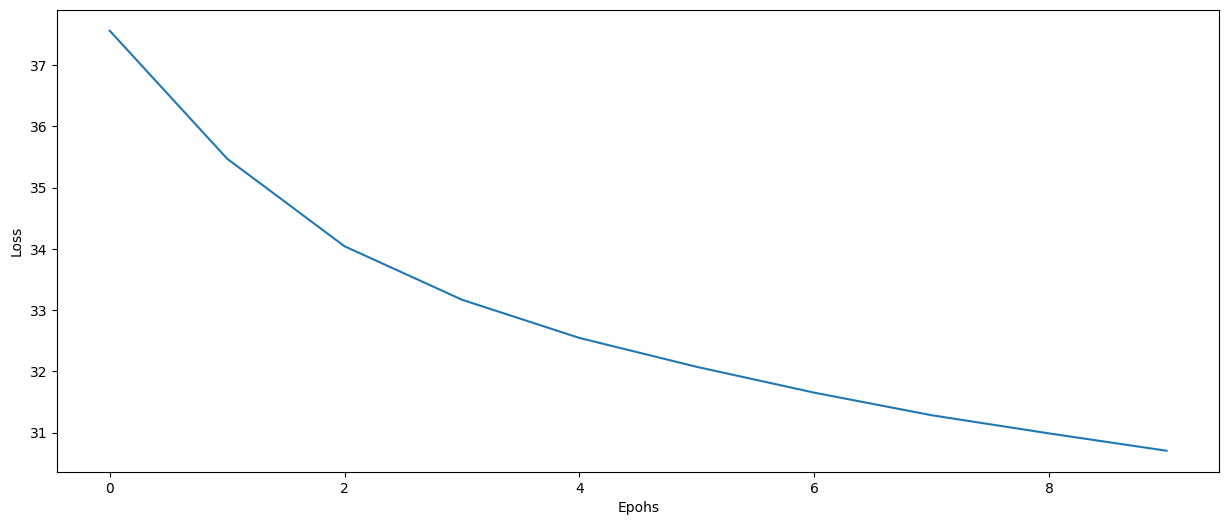

In [ ]:
plt.figure (figsize = (15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-")
plt.xlabel("Epohs")
plt.ylabel("Loss")

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

#Полносвязная сеть

In [ ]:
class IsDiabetSuperNn(nn.Module):
  def __init__(self, input, output):
    super().__init__()

    self.l1 = nn.Linear(input, 20)
    self.l2 = nn.Linear(20, 20)
    self.l3 = nn.Linear(20, 10)
    self.l4 = nn.Linear(10, output)

    self.relu = F.relu

  def forward(self, x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.relu(x)
    x = self.l4(x)
    return x



In [ ]:
#создание модели
model = IsDiabetSuperNn(21, 1)

#функция потерь
loss_function = nn.BCEWithLogitsLoss()
#оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
#помещаем всё на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary').to(DEVICE)

loses_train = []
total_loss = []

acc_val = []

#общее колиичество эпох
epochs = 30

for epoch in tqdm(range (epochs)):
  for i, (x_batch, y_batch) in enumerate(train_loader):
    #перевод модели в режим обучения
    model.train()

    #обнуение градиента оптимизатора
    optimizer.zero_grad()

    #прямой проход
    outputs = model(x_batch.to(DEVICE))
    outputs = outputs.view(-1) #преобразрвание "выравнивание" в одномерный тензор

    loss = loss_function(outputs, y_batch.to(DEVICE))
    loss.backward()

    loses_train.append(loss.detach().cpu().numpy().item())

    optimizer.step()

  #средняя ошибка в эпохе
  loss1 = np.mean(loses_train)
  total_loss.append(loss1)
  # print("loss: " + str(loss1))

  #валидация
for i, (x_batch, y_batch) in enumerate(val_loader):
    model.eval()
    with torch.no_grad():
      outputs = model(x_batch.to(DEVICE))
      outputs = outputs.view(-1)
      loss = loss_function(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

#средняя точность
acc = np.mean(acc_val)
print(f"Accuracy полносвязной модели {acc:.2%}")


100%|██████████| 30/30 [00:54<00:00,  1.81s/it]


Accuracy линейной модели 75.04%


Text(0, 0.5, 'Loss')

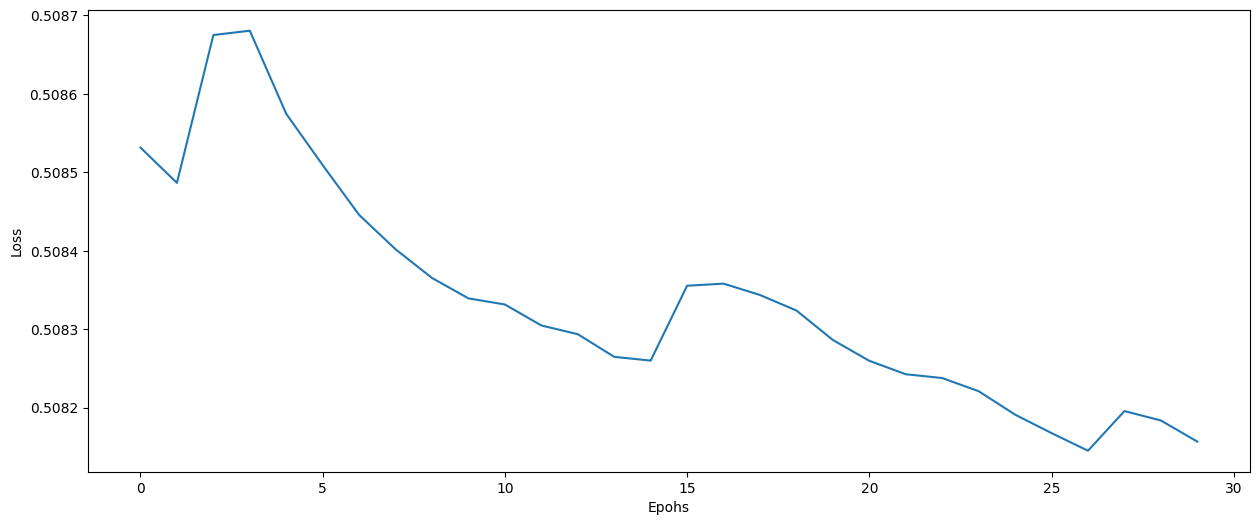

In [ ]:
plt.figure (figsize = (15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-")
plt.xlabel("Epohs")
plt.ylabel("Loss")